In [1]:
from collections import namedtuple
ParseTree = namedtuple("ParseTree", "logic_symbol left_child right_child")
# t1 = ParseTree("not", ParseTree("and", "A1", "A2"), None)
# isinstance(t1, ParseTree) => True
# isinstance(t1.left_child.left_child, str) => True # A1, sentence symbols, are strings

logic_symbols = ["implies", "iff", "and", "or", "not"]
parentheses = ["(", ")"]

def tokenize(exp):
    """
    Returns the tokens of an expression
    """
    return exp.split()

def parse_aux(exp):
    if len(exp) == 0:
        # for example, ["(", "not", ")"][2:-1] => []
        # also, ["(", "not"][2:-1] => []
        return False
    if len(exp) == 1:
        if exp[0] in logic_symbols + parentheses:
            return False # parse error, should be a sentence symbol
        return exp[0] # sentence symbol as string
    # the first symbol must be (.
    if exp[0] != "(":
        return False
    if len(exp) >= 1 and exp[1] == "not":
        left_child = parse_aux(exp[2:-1])
        if not left_child:
            return False
        return ParseTree("not", left_child, None)
    count_left_paren, count_right_paren = 0, 0
    for i, token in enumerate(exp[1:]):
        if (token == "("):
            count_left_paren += 1
        if (token == ")"):
            count_right_paren += 1
        # scan the expression from the left until first reaching (alpha 
        # where alpha is an expression having a balance between left and right parentheses
        if count_left_paren == count_right_paren:
            alpha = exp[1:i+2]
            # next symbol should exist and should be a logic symbol
            if len(exp) < i+3:
                return False
            # the next symbol must be a logic symbol and is the prinipal connective
            logic_symbol = exp[i+2]
            if logic_symbol not in logic_symbols:
                return False
            # the remainder of the expression, beta) must consist of an expression beta and a right parenthesis
            if exp[-1] != ")":
                return False
            beta = exp[i+3:-1]
            left_child = parse_aux(alpha)
            right_child = parse_aux(beta)
            if not right_child or not left_child:
                return False
            return ParseTree(logic_symbol, left_child, right_child)
    # if the end of the expression is reached before finding such an alpha, then the original expression
    # is not a wff.
    return False

def parse(exp):
    """
    Enderton pg. 41 "An algorithm"
    if exp is a wff, returns the parse tree
    if not, returns False
    """
    return parse_aux(tokenize(exp))

In [2]:
print(parse("( A and B )"))

print(parse("( ( A and B ) implies ( C or ( not D ) ) )"))

print(parse("( not A )"))

print(parse(""))

print(parse("("))

print(parse("( a and b )"))

print(parse("(a and b)"))

ParseTree(logic_symbol='and', left_child='A', right_child='B')
ParseTree(logic_symbol='implies', left_child=ParseTree(logic_symbol='and', left_child='A', right_child='B'), right_child=ParseTree(logic_symbol='or', left_child='C', right_child=ParseTree(logic_symbol='not', left_child='D', right_child=None)))
ParseTree(logic_symbol='not', left_child='A', right_child=None)
False
False
ParseTree(logic_symbol='and', left_child='a', right_child='b')
False


In [3]:
def polish_notation_aux(exp):
    """
    pre order tree traversal
    """
    if exp is None:
        # case of 'not'
        return ""
    if isinstance(exp, str):
        return exp
    return exp.logic_symbol + " " + polish_notation_aux(exp.left_child) + " " + polish_notation_aux(exp.right_child)
    
def polish_notation(exp):
    parse_exp = parse(exp)
    if not parse_exp:
        return False
    return polish_notation_aux(parse_exp)

In [4]:
polish_notation("( ( A and B ) implies ( C or ( not D ) ) )")

'implies and A B or C not D '

In [5]:
def evaluate_aux(exp, sentence_symbol_map):
    if exp is None:
        return None
    if isinstance(exp, str):
        if exp not in sentence_symbol_map:
            return False
        return sentence_symbol_map[exp]
    eval_left = evaluate_aux(exp.left_child, sentence_symbol_map)
    eval_right = evaluate_aux(exp.right_child, sentence_symbol_map)
    if exp.logic_symbol == "not":
        return not eval_left
    if exp.logic_symbol == "and":
        return eval_left and eval_right
    if exp.logic_symbol == "or":
        return eval_left or eval_right
    if exp.logic_symbol == "implies":
        return not eval_left or eval_right
    if exp.logic_symbol == "iff":
        return eval_left == eval_right
    raise ValueError
    
def evaluate(exp, sentence_symbol_map):
    """
    Given an expression and a map of sentence symbols onto True and False, evaluate the expression.
    any sentence symbol not in map is assumed to be False.
    """
    parse_exp = parse(exp)
    if not parse_exp:
        return "Failed to Parse"
    return evaluate_aux(parse_exp, sentence_symbol_map)

In [6]:
print(evaluate("( ( A and B ) implies ( C or ( not D ) ) )", {"A": True, "B": True, "C": False, "D": False}))
print(evaluate("( ( A and B ) implies ( C or ( not D ) ) )", {"A": True, "B": True, "C": False, "D": True}))

True
False


In [7]:
def sentence_symbols(exp):
    return sorted(list(set(tokenize(exp)) - set(logic_symbols + parentheses)))

In [8]:
print(sentence_symbols("( ( A and D ) implies ( C or ( not D ) ) )"))

['A', 'C', 'D']


In [9]:
def all_assignments(n):
    if n == 0:
        return [[]]
    all_assign = all_assignments(n-1)
    return [[False] + assign  for assign in all_assign] + [[True] + assign for assign in all_assign]

In [10]:
all_assignments(2)

[[False, False], [False, True], [True, False], [True, True]]

In [11]:
dict(zip(['A','B'], [False, False]))

{'A': False, 'B': False}

In [12]:
def satisfiable(exp):
    sent_sym = sentence_symbols(exp)
    return any(evaluate(exp, dict(zip(sent_sym, assign))) for assign in all_assignments(len(sent_sym)))
#     sat = False
#     for assign in all_assignments(len(sent_sym)):
#         d = dict(zip(sent_sym, assign))
#         if evaluate(exp, d):
#             print("Satisfied by: " + str(d))
#             sat = True
#         else:
#             print("Not satisfied by: " + str(d))
#     return sat

In [13]:
def tautology(exp):
    sent_sym = sentence_symbols(exp)
    return all(evaluate(exp, dict(zip(sent_sym, assign))) for assign in all_assignments(len(sent_sym)))
#     taut = True
#     for assign in all_assignments(len(sent_sym)):
#         d = dict(zip(sent_sym, assign))
#         if not evaluate(exp, d):
#             print("Contradicted by: " + str(d))
#             taut = False
#     return taut

In [14]:
print(satisfiable("( ( A and B ) implies ( C or ( not D ) ) )"))
print(tautology("( A iff A )"))
print(tautology("( A implies ( A or B ) )"))
print(tautology("( A iff ( A or B ) )"))

True
True
True
False


In [15]:
def join_and(exps):
    if len(exps) == 1:
        return exps[0]
    return "( " + exps[0] + " and " + join_and(exps[1:]) + " )"

In [16]:
print(join_and(["( ( A and B ) implies ( C or ( not D ) ) )"]))
print(join_and(["( ( A and B ) implies ( C or ( not D ) ) )", "( ( A and B ) implies ( C or ( not D ) ) )"]))

( ( A and B ) implies ( C or ( not D ) ) )
( ( ( A and B ) implies ( C or ( not D ) ) ) and ( ( A and B ) implies ( C or ( not D ) ) ) )


In [17]:
def tautologically_implies(exps, exp):
    """
    returns true if exp is tautologically implied by exps
    """
    if len(exps) == 0:
        return tautology(exp)
    return tautology("( " + join_and(exps) + " implies " + exp + " )")

def tautologically_equivalent(exp1, exp2):
    """
    returns true if exp1 is tautologically equivalent to exp2
    """
    return tautology("( " + exp1 + " iff " + exp2 + " )")

In [18]:
print(tautologically_implies(["A"], "( A or B )"))
print(tautologically_equivalent("( not ( A or B ) )", "( ( not A ) and ( not B ) )"))

True
True


In [19]:
def parse_tree_to_exp(parse_tree):
    if isinstance(parse_tree, str):
        return parse_tree
    if parse_tree.logic_symbol == 'not':
        return '( not ' + parse_tree_to_exp(parse_tree.left_child) + ' )'
    return ' '.join(['(', parse_tree_to_exp(parse_tree.left_child), 
                    parse_tree.logic_symbol, parse_tree_to_exp(parse_tree.right_child), ')'])

def substitute_aux(exp, sentence_symbol, sub_exp):
    if exp is None:
        # case of 'not'
        return None
    if isinstance(exp, str):
        if exp == sentence_symbol:
            return sub_exp
        return exp
    return ParseTree(exp.logic_symbol, substitute_aux(exp.left_child, sentence_symbol, sub_exp),
                     substitute_aux(exp.right_child, sentence_symbol, sub_exp))
    
def substitute(exp, sentence_symbol, sub_exp):
    """
    substitute sub_exp into exp wherever sentence_symbol appears in exp.
    """
    return parse_tree_to_exp(substitute_aux(parse(exp), sentence_symbol, sub_exp))

In [20]:
substitute("( A or ( not A ) )", "A", "( C and D )")

'( ( C and D ) or ( not ( C and D ) ) )'

In [21]:
print(tautology("( A or ( not A ) )"))
print(tautology(substitute("( A or ( not A ) )", "A", "( C and D )")))

True
True


In [22]:
def dual_exp(exp):
    """
    returns the expression in which 'and' is interchanged for 'or' and vice versa, and sentence symbols with their negations.
    """
    tok_exp = tokenize(exp)
    tok_exp = ["_or" if tok == "and" else "_and" if tok == "or" else "( not " + tok + " )" 
               if tok not in logic_symbols + parentheses else tok for tok in tok_exp]
    tok_exp = ["or" if tok == "_or" else "and" if tok == "_and" else tok for tok in tok_exp]
    return " ".join(tok_exp)

In [23]:
exp = "( ( A and B ) or ( C or ( not D ) ) )"
print(dual_exp(exp))
print(tautologically_equivalent(dual_exp(exp), "( not " + exp + " )"))

( ( ( not A ) or ( not B ) ) and ( ( not C ) and ( not ( not D ) ) ) )
True


In [24]:
def independent_equivalent_subset(exps):
    """
    Returns a subset of exps that are independent but still equivalent to exps.
    """
    exps_set = set(exps)
    while True:
        independent = True
        for exp in exps_set:
            tmp = list(exps_set - set([exp]))
            if tautologically_implies(tmp, exp):
                # print(tmp, "taut implies", exp)
                independent = False
                exps_set = exps_set - set([exp])
                break
        if independent == True:
            return list(exps_set)

In [25]:
print(independent_equivalent_subset(["( A and B )", "A", "B"]))
print(independent_equivalent_subset(["A", "( A or B )"]))
print(independent_equivalent_subset(["( not ( A or B ) )", "( ( not A ) and ( not B ) )"]))

['( A and B )']
['A']
['( not ( A or B ) )']


In [1]:
import nltk

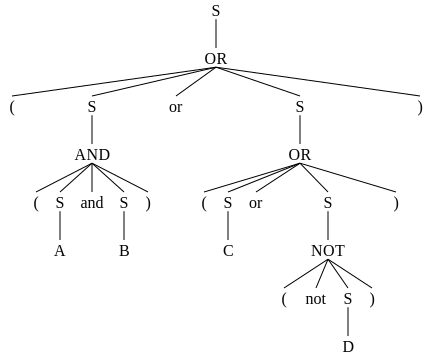

In [2]:
logic_symbols = ["implies", "iff", "and", "or", "not"]
parentheses = ["(", ")"]

def tokenize(exp):
    """
    Returns the tokens of an expression
    """
    return exp.split()

sentential_logic_grammar1 = nltk.CFG.fromstring("""
    S -> AND
    S -> OR
    S -> IMPLIES
    S -> IFF
    S -> NOT
    AND -> '(' S 'and' S ')'
    OR -> '(' S 'or' S ')'
    IMPLIES -> '(' S 'implies' S ')'
    IFF -> '(' S 'iff' S ')'
    NOT -> '(' 'not' S ')'
    S -> 'A'
    S -> 'B'
    S -> 'C'
    S -> 'D'
    """)
parser1 = nltk.ChartParser(sentential_logic_grammar1)
exp = "( ( A and B ) or ( C or ( not D ) ) )"
sent = tokenize(exp)
list(parser1.parse(sent))[0]

In [3]:
def removeSymbols(tree, remove_symbols):
    if isinstance(tree, str):
        return tree
    return nltk.tree.Tree(tree.label(), [removeSymbols(child, remove_symbols) for child in tree 
                                         if child not in remove_symbols])

def removeS(tree):
    if isinstance(tree, str):
        return tree
    if tree.label() == "S":
        return removeS(tree[0])
    return nltk.tree.Tree(tree.label(), [removeS(child) for child in tree])

def pruneTree(tree, remove_symbols):
    return removeS(removeSymbols(tree, remove_symbols))

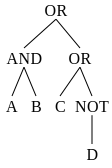

In [4]:
x1 = list(parser1.parse(sent))[0]
pruneTree(x1, logic_symbols + parentheses)

In [5]:
def parse(exp):
    logic_symbols = ["implies", "iff", "and", "or", "not"]
    parentheses = ["(", ")"]
    
    sentential_logic_grammar = nltk.CFG.fromstring("""
    S -> AND
    S -> OR
    S -> IMPLIES
    S -> IFF
    S -> NOT
    AND -> '(' S 'and' S ')'
    OR -> '(' S 'or' S ')'
    IMPLIES -> '(' S 'implies' S ')'
    IFF -> '(' S 'iff' S ')'
    NOT -> '(' 'not' S ')'
    S -> 'A'
    S -> 'B'
    S -> 'C'
    S -> 'D'
    """)
    parser = nltk.ChartParser(sentential_logic_grammar)
    sent = tokenize(exp)
    try:
        p = parser1.parse(sent)
        return pruneTree(list(p)[0], logic_symbols + parentheses)
    except ValueError as e:
        return e
    except IndexError as e:
        return "Failed to Parse"

In [6]:
print(parse("( ( A and B ) implies ( C or ( not D ) ) )"))
print(parse("( ( A and B ) and ( C or ( not D ) ) )"))
print(isinstance(parse("( ( A and B ) and ( C or ( not D ) ) )"), nltk.tree.Tree))
print(parse("( ( A and B ) and ( C or ( not D ) ) ) )"))
print(parse("( ( A and B ) nand ( C or ( not D ) ) )"))

(IMPLIES (AND A B) (OR C (NOT D)))
(AND (AND A B) (OR C (NOT D)))
True
Failed to Parse
Grammar does not cover some of the input words: "'nand'".


In [7]:
def evaluate_aux(exp, sentence_symbol_map):
    if isinstance(exp, str):
        if exp not in sentence_symbol_map:
            return False
        return sentence_symbol_map[exp]
    if exp.label() == "NOT":
        return not evaluate_aux(exp[0], sentence_symbol_map)
    eval_left = evaluate_aux(exp[0], sentence_symbol_map)
    eval_right = evaluate_aux(exp[1], sentence_symbol_map)
    if exp.label() == "AND":
        return eval_left and eval_right
    if exp.label() == "OR":
        return eval_left or eval_right
    if exp.label() == "IMPLIES":
        return not eval_left or eval_right
    if exp.label() == "IFF":
        return eval_left == eval_right
    raise ValueError
    
def evaluate(exp, sentence_symbol_map):
    """
    Given an expression and a map of sentence symbols onto True and False, evaluate the expression.
    any sentence symbol not in map is assumed to be False.
    """
    p = parse(exp)
    if not isinstance(p, nltk.tree.Tree):
        return p
    return evaluate_aux(p, sentence_symbol_map)

In [8]:
print(evaluate("( ( A and B ) and ( C or ( not D ) ) )", {"A": True, "B": True, "C": False, "D": False}))
print(evaluate("( ( A and B ) and ( C or ( not D ) ) )", {"A": True, "B": True, "C": False, "D": True}))
print(evaluate("( ( A and B ) implies ( C or ( not D ) ) )", {"A": True, "B": True, "C": False, "D": False}))
print(evaluate("( ( A and B ) implies ( C or ( not D ) ) )", {"A": True, "B": True, "C": False, "D": True}))

True
False
True
False


In [9]:
def tokenize_english(exp, logic_symbols):
    toks = exp.split(" ")
    comb_toks = []
    for tok in toks:
        if tok in logic_symbols or (len(comb_toks) and comb_toks[-1] in logic_symbols):
            comb_toks.append(tok)
            if tok == "not" and len(comb_toks) >= 2 and comb_toks[-2] not in logic_symbols:
                # if not is in the middle of a simple phrase, move it to the beginning by swapping.
                comb_toks[-1] = comb_toks[-2]
                comb_toks[-2] = 'not'
        else:
            # This case is just because 'not' needn't be the start, and so a non-logical symbol can start a wff.
            if len(comb_toks) == 0:
                comb_toks.append(tok)
            else:
                comb_toks[-1] += " " + tok
    return comb_toks

def parse_english(exp):
    logic_symbols = ["either", "or", "both", "and", "not", "if", "then"]
    sent = tokenize_english(exp, logic_symbols)
    basics = "\n".join(["S -> '" + b + "'" for b in set(sent) - set(logic_symbols)])

    sentential_logic_grammar = nltk.CFG.fromstring("""
    S -> AND
    S -> OR
    S -> IMPLIES
    S -> NOT
    AND -> 'both' S 'and' S
    OR -> 'either' S 'or' S
    IMPLIES -> 'if' S 'then' S
    NOT -> 'not' S
    """ + basics)    
    parser = nltk.ChartParser(sentential_logic_grammar)
    try:
        p = parser.parse(sent)
        return pruneTree(list(p)[0], logic_symbols)
    except ValueError as e:
        return e
    except IndexError as e:
        return "Failed to Parse"

['not', 'the sun is shining']
['not', 'the sun is shining']
['either', 'both', 'it is raining', 'and', 'the plants grow', 'or', 'not', 'the sun is shining']


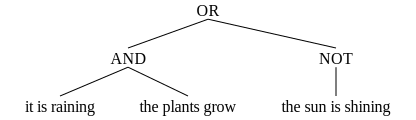

In [10]:
print(tokenize_english("not the sun is shining",
                ["either", "or", "both", "and", "not", "if", "then"]))
print(tokenize_english("the sun is not shining",
                ["either", "or", "both", "and", "not", "if", "then"]))
print(tokenize_english("either both it is raining and the plants grow or the sun is not shining",
                ["either", "or", "both", "and", "not", "if", "then"]))
parse_english("either both it is raining and the plants grow or the sun is not shining")

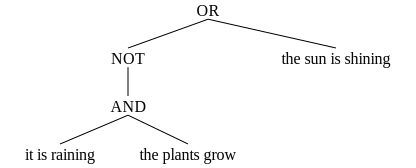

In [11]:
parse_english("either not both it is raining and the plants grow or the sun is shining")

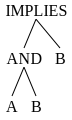

In [12]:
parse_english("if both A and B then B")

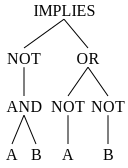

In [13]:
parse_english("if not both A and B then either not A or not B")

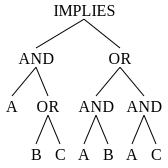

In [14]:
parse_english("if both A and either B or C then either both A and B or both A and C")

In [15]:
def all_assignments(n):
    if n == 0:
        return [[]]
    all_assign = all_assignments(n-1)
    return [[False] + assign  for assign in all_assign] + [[True] + assign for assign in all_assign]

def sentence_symbols(exp, logic_symbols):
    return sorted(list(set(tokenize_english(exp, logic_symbols)) - set(logic_symbols)))

def satisfiable(exp):
    logic_symbols = ["either", "or", "both", "and", "not", "if", "then"]
    sent_sym = sentence_symbols(exp, logic_symbols)
    return any(evaluate_aux(parse_english(exp), dict(zip(sent_sym, assign))) for assign in all_assignments(len(sent_sym)))

def tautology(exp):
    logic_symbols = ["either", "or", "both", "and", "not", "if", "then"]
    sent_sym = sentence_symbols(exp, logic_symbols)
    return all(evaluate_aux(parse_english(exp), dict(zip(sent_sym, assign))) for assign in all_assignments(len(sent_sym)))

In [16]:
print(satisfiable("if both A and either B or C then either both A and B or both A and C"))
print(tautology("if both A and either B or C then either both A and B or both A and C"))

True
True


In [17]:
print(satisfiable("both A and not A"))
print(tautology("if not both A and B then either not A or not B"))

False
True
